In [23]:
import sys
sys.path.append("../Modules/")
sys.path.append("../")
import os

import pandas as pd
import numpy as np

from configobj import ConfigObj
from configobj import flatten_errors
from validate import Validator
    
import logging

from analysisParameters import loadParameters
from loadDataE1 import loadSessionDict
import processDataE1 as pF

from scipy.interpolate import interp1d

#fmt = 'logging.Formatter(''%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
fmt = '%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
logging.basicConfig(level=logging.INFO, format=fmt)
logger = logging.getLogger(__name__)



In [24]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [25]:
# sessionDict = projectTrajectories(sessionDict)
import matplotlib.pyplot as plt
%matplotlib notebook

In [42]:
subNum = 1
bNum = 2
tNum = 100


In [43]:
def plotGazeData(dF,timeColumnLabel, velColumnLabels, 
                 xLim=[0,1],yLim=[0 ,120],winRange = False,width=800,height=600,
                 inline=True,ytitle='velocity (pix/s)'):

    traces = []
    
    colors_idx = ['rgb(0,204,204)','rgb(128,128,128)','rgb(204,0,0)','rgb(102,0,204)',
                 'rgb(50,50,204)']

    time_fr = np.array(dF[timeColumnLabel]) #- dF[timeColumnLabel].iloc[0])

    for idx, columnName in enumerate(velColumnLabels):
        
        scatterObj = go.Scatter(
        x=time_fr,
        y=dF[columnName],
        name = columnName,
        line = dict(color = colors_idx[idx],width=3),
        opacity = 0.8)

        traces.append(scatterObj)

    if winRange is False:
        winRange = [0,1]
        
    layout = dict(
        dragmode= 'pan',
        width=width,
        height=height,
        yaxis=dict(range=yLim, title=ytitle),
        xaxis=dict(
            rangeslider=dict(),
            type='time',
            range=winRange,
            title='time',
        )
    )
    
    fig = dict(data=traces, layout=layout)
    return fig
    

In [44]:
fileTimeList = [];
[fileTimeList.append(name) for name in os.listdir("../Data/") if name[0] is not '.'];
fileTimeList

from analysisParameters import loadParameters
from loadDataE1 import loadSessionDict
from processDataE1 import projectTrajectories

fileName = fileTimeList[subNum]
analysisParameters = loadParameters(fileName)

# set loadProcessedData to True if you want to reprocess the file.  
sessionDict = loadSessionDict(analysisParameters,
                                  loadParsedData = True,
                                  loadProcessedData = True)

sessionDict['processed']['subjectNumber'] = subNum
sessionDict['processed']['fileName'] = fileName

from processDataE1 import calcSMIDeltaT
sessionDict = calcSMIDeltaT(sessionDict)


INFO_loadDataE1-loadSessionDict(): - Loading preprocessed data for exp_data-2018-4-26-11-31 ***
INFO_processDataE1-calcSMIDeltaT(): - Added sessionDict['processed']['smiDeltaT']


In [45]:
from processDataE1 import gazeAnalysisWindow
sessionDict = gazeAnalysisWindow(sessionDict, analyzeUntilXSToArrival =  .3, 
                                 stopAtXSToArrival = 0.1)



INFO_processDataE1-gazeAnalysisWindow(): - Added sessionDict['trialInfo']['analysisStartFr']
INFO_processDataE1-gazeAnalysisWindow(): - Added sessionDict['trialInfo']['analysisEndFr']


In [46]:
tr = sessionDict['processed'].groupby(('blockNumber','trialNumber')).get_group((bNum,tNum))
trInfo = sessionDict['trialInfo'].groupby(('blockNumber','trialNumber')).get_group((bNum,tNum))

### Parameters

In [47]:
from scipy.signal import savgol_filter

winSizeMS = 20
polyorder = 3
interpResS = .001
frameDur = np.float(sessionDict['raw']['frameTime'].diff().mode())

### Vector movement model

# Interpolate trial data

In [48]:
winStartTimeMs = analysisParameters['analysisWindowStart']
winEndTimeMs = analysisParameters['analysisWindowEnd']



initTTC = float(trInfo['ballInitialPos','Z']) / -float(trInfo['ballInitialVel','Z'])

# Analysis should focus on the frames before ball collision or passing
trialTime_fr = np.array(tr['frameTime'],np.float) - np.array(tr['frameTime'],np.float)[0]
endFrameIdx = np.where( trialTime_fr > initTTC )[0][0]
lastTrajFrame = np.min([int(endFrameIdx),
           int(trInfo[('passVertPlaneAtPaddleFr', '')])])

interpTime_s = np.arange(0,trialTime_fr[-1],interpResS)
analysisTime_fr = np.array(tr['frameTime'],np.float)[:lastTrajFrame] - np.array(tr['frameTime'],np.float)[0]

winStartTimeMs = analysisParameters['analysisWindowStart']
winEndTimeMs = analysisParameters['analysisWindowEnd']

ttcEndSampleFr = np.where( tr['frameTime']-tr['frameTime'].iloc[0] > initTTC )[0][0]-1
ttcEndSampleIdx = np.where( interpTime_s > initTTC )[0][0]-1

winStartSampleIdx = np.where( interpTime_s > initTTC + winStartTimeMs/1000.0 )[0][0]
winEndSampleIdx = np.where( interpTime_s > initTTC + winEndTimeMs/1000.0 )[0][0]


# Inspect an interpolated expansion signal

In [49]:

##########################################################
## Radius Method 1

winSizeSamples = 5

ballExpansionRate_fr = savgol_filter(tr['ballRadiusDegs'].values*2.0, winSizeSamples, polyorder=3, deriv=1, 
                                      delta = frameDur, axis=0, mode='interp')

iFun = interp1d(trialTime_fr, ballExpansionRate_fr)
ballExpansionRate_s = iFun(interpTime_s)

##########################################################
## Radius Method 2

iFun = interp1d(trialTime_fr, np.array(tr['ballRadiusDegs']))
ballRadius_s = iFun(interpTime_s)

ballExpansionRateB_s = np.diff(ballRadius_s)
ballExpansionRateB_s = np.hstack([0, ballExpansionRateB_s / np.float(interpResS)])


<IPython.core.display.Javascript object>


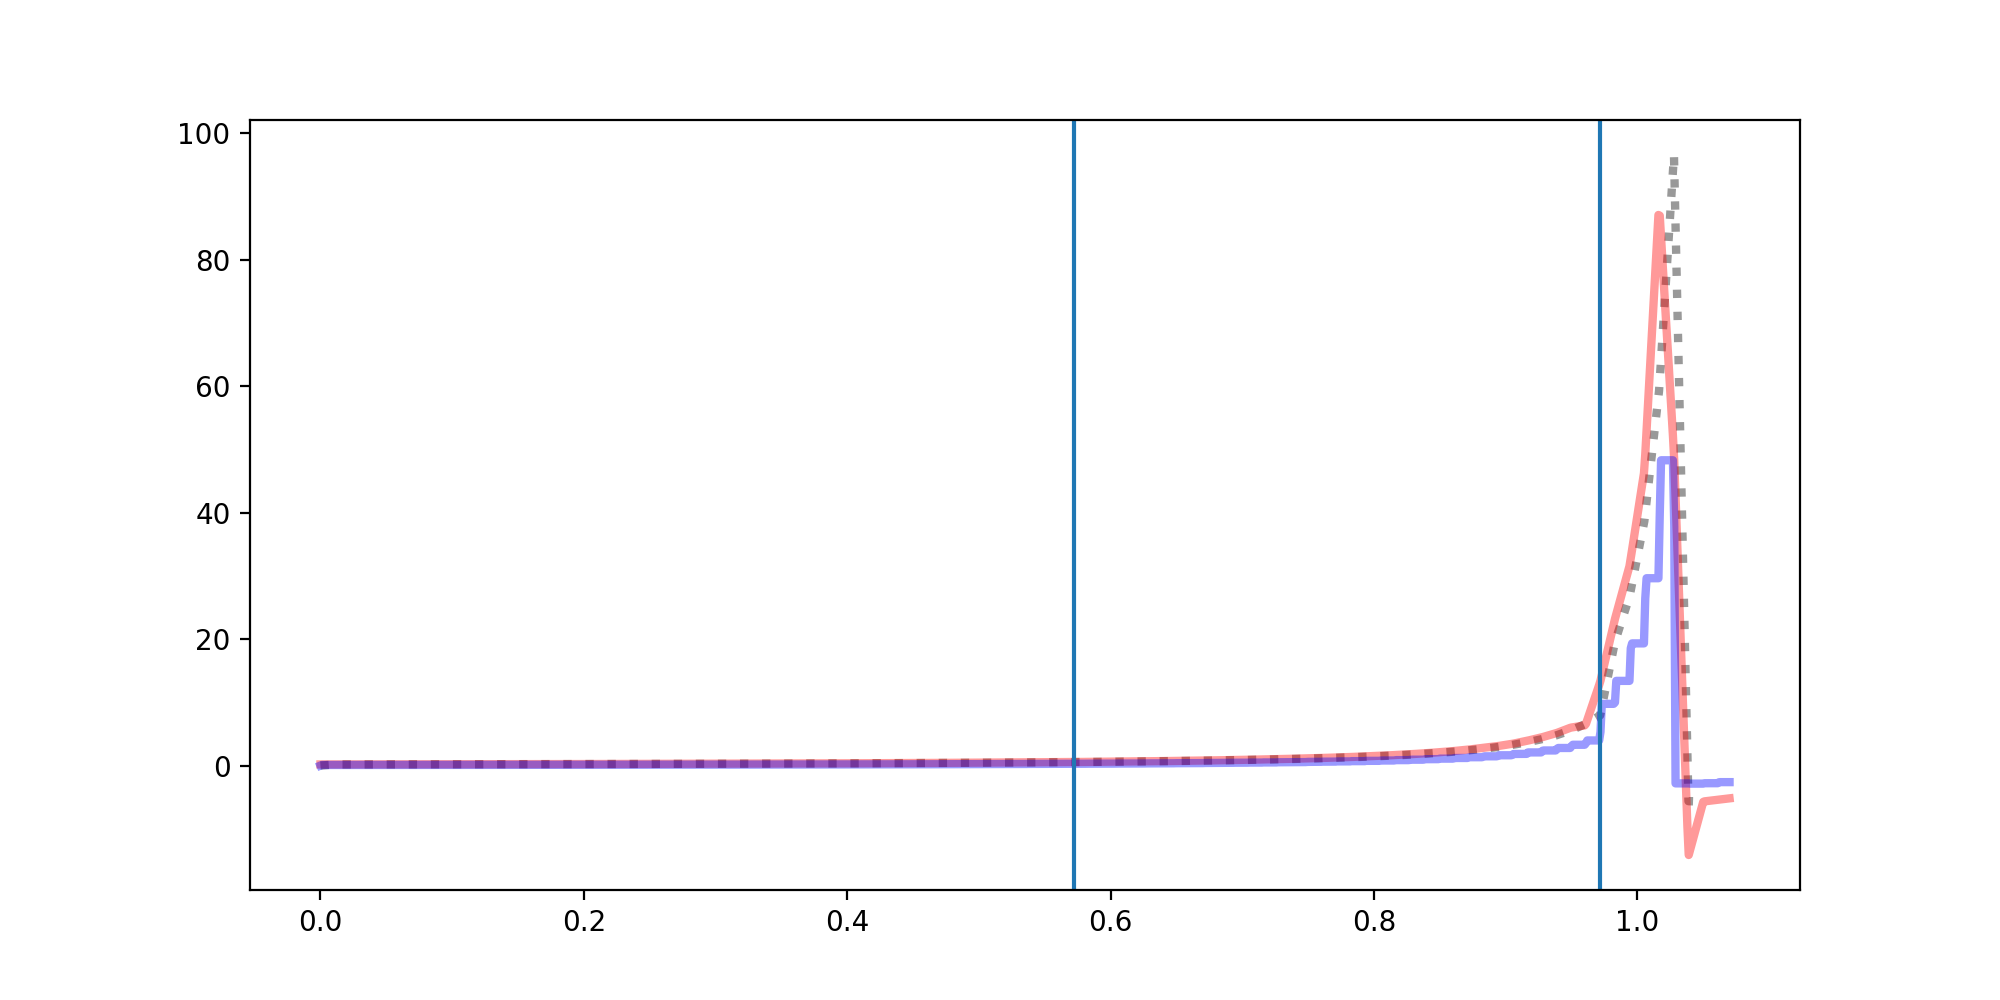

In [50]:
p, ax = plt.subplots(1, 1,figsize=(10,5)) #sharey=True)

# initTTC = float(trInfo['ballInitialPos','Z']) / -float(trInfo['ballInitialVel','Z'])

# ttcEndSampleFr = np.where( tr['frameTime']-tr['frameTime'].iloc[0] > initTTC )[0][0]-1
# ttcEndSampleIdx = np.where( interpTime_s > initTTC )[0][0]-1

# winStartSampleIdx = np.where( interpTime_s > initTTC + winStartTimeMs/1000.0 )[0][0]
# winEndSampleIdx = np.where( interpTime_s > initTTC + winEndTimeMs/1000.0 )[0][0]

lineHandles = []

rawExpRate_fr = np.hstack([0,np.diff(tr['ballRadiusDegs'].values*2.0) /  np.diff(tr['frameTime']) ])

ax.plot(trialTime_fr[:ttcEndSampleFr],
        rawExpRate_fr[:ttcEndSampleFr],
        ':k',linewidth=3,alpha = 0.4)


ax.plot(interpTime_s[:ttcEndSampleIdx],
        ballExpansionRate_s[:ttcEndSampleIdx],
        color='r',linewidth=3,alpha = 0.4)

ax.plot(interpTime_s[:ttcEndSampleIdx],
        ballExpansionRateB_s[:ttcEndSampleIdx],
        color='b',linewidth=3,alpha = 0.4)


p.set_facecolor('w')
ax.axvline( interpTime_s[winStartSampleIdx] )
ax.axvline( interpTime_s[winEndSampleIdx] )

# Inspect an interpolated gaze signal

In [71]:
##########################################################
## Method 1

interpTime_s = np.arange(0,trialTime_fr[-1],interpResS)
iFun = interp1d(trialTime_fr, np.array(tr['cycGIW_az'].fillna(0)),kind='cubic')
interpGazeAz_s = iFun(interpTime_s) 
interpGazeAzVel_s = np.hstack([0, np.diff(interpGazeAz_s)/interpResS])

##########################################################
## Method 2

winSizeSamples = 5

gazeAzVel_fr = savgol_filter(tr['cycGIW_az'].values, winSizeSamples, polyorder=3, deriv=1, 
                                      delta = frameDur, axis=0, mode='interp')

iFun = interp1d(trialTime_fr,gazeAzVel_fr) #,kind='cubic')
interpGazeAzVelB_s = iFun(interpTime_s)


##########################################################
## Method 3

winSizeSamples = 5

rawGazeVelAz_fr = np.hstack([0,np.diff(tr['cycGIW_az'].values) /  np.diff(tr['frameTime']) ])
gazeAzVel_fr = savgol_filter(rawGazeVelAz_fr, winSizeSamples, polyorder=3, deriv=0, 
                                      delta = frameDur, axis=0, mode='interp')

iFun = interp1d(trialTime_fr,gazeAzVel_fr) #,kind='cubic')
interpGazeAzVelC_s = iFun(interpTime_s)

##########################################################
## Method 4

winSizeSamples = 5

gazeAzVel_fr = savgol_filter(tr['cycGIW_az'].values, winSizeSamples, polyorder=3, deriv=0, 
                                      delta = frameDur, axis=0, mode='interp')

gazeAzVel_fr = np.hstack([0,np.diff(gazeAzVel_fr) /  np.diff(tr['frameTime']) ])


iFun = interp1d(trialTime_fr,gazeAzVel_fr) #,kind='cubic')
interpGazeAzVelD_s = iFun(interpTime_s)



In [72]:
# p, ax = plt.subplots(1, 1,figsize=(10,5)) #sharey=True)


# lineHandles = []

# # rawGazeVelAz_fr = np.hstack([0,np.diff(tr['cycGIW_az'].values*2.0) /  np.diff(tr['frameTime']) ])

# ax.plot(trialTime_fr[:ttcEndSampleFr],
#         rawGazeVelAz_fr[:ttcEndSampleFr],
#         ':k',linewidth=3,alpha = 0.4)


# ax.plot(interpTime_s[:ttcEndSampleIdx],
#         interpGazeAzVel_s[:ttcEndSampleIdx],
#         color='r',linewidth=3,alpha = 0.4)

# ax.plot(interpTime_s[:ttcEndSampleIdx],
#         interpGazeAzVelB_s[:ttcEndSampleIdx],
#         color='b',linewidth=3,alpha = 0.4)


# ax.plot(interpTime_s[:ttcEndSampleIdx],
#         interpGazeAzVelC_s[:ttcEndSampleIdx],
#         color='g',linewidth=3,alpha = 0.4)

# # ax.set_xlim([.6,1.])
# # ax.set_xlim([.05,.15])
# ax.set_ylim([-50,100])
# p.set_facecolor('w')
# ax.axvline( interpTime_s[winStartSampleIdx] )
# ax.axvline( interpTime_s[winEndSampleIdx] )


In [73]:
plotData = pd.DataFrame({'time' : interpTime_s,
              'interpGazeAzVel_s': interpGazeAzVel_s,
              'interpGazeAzVelB_s': interpGazeAzVelB_s,
              'interpGazeAzVelC_s': interpGazeAzVelC_s,
                         'interpGazeAzVelD_s': interpGazeAzVelD_s,
             })

In [74]:
# gbProc_bl_tr = sessionDict['processed'].groupby(('blockNumber','trialNumber'))
# tr = gbProc_bl_tr.get_group((2,6))
# (startFr, endFr) = findAnalysisWindow(tr)

p = plotGazeData(plotData,'time', 
           ['interpGazeAzVel_s','interpGazeAzVelB_s','interpGazeAzVelC_s','interpGazeAzVelD_s'],
           winRange=[plotData['time'].iloc[winStartSampleIdx],
                     plotData['time'].iloc[winEndSampleIdx]],
           yLim=[-100,500],ytitle='degrees azimuth/elevation')



# ax.plot(trialTime_fr[:ttcEndSampleFr],
#         rawGazeVelAz_fr[:ttcEndSampleFr],
#         ':k',linewidth=3,alpha = 0.4)

newTrace = go.Scatter(
    x = trialTime_fr,
    y = rawGazeVelAz_fr,
    mode = 'lines+markers',
    name = 'raw',
    line = dict(color = 'rgb(0,50,50)',width=2),
    marker = dict(color = 'rgb(0,50,50)',size=7),
    opacity = 0.8)

p['data'].append(newTrace)   

iplot(p)

# What did we learn?

filter (if needed) then differentiate, then interpolate